In [1]:
# General
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
%matplotlib inline

# ML
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import joblib
from xgboost import XGBRegressor 

# Cp 
from cp_app.utils import select_structures
from cp_app.descriptors import cv_features
from cp_app.predictions import predict_Cv_ensemble_dataset

# others
import warnings
warnings.filterwarnings('ignore')

/Users/moosavi/miniconda3/envs/cpenv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Setting up the model, target, and features

In [2]:

FEATURES = cv_features
TARGET = 'pCv_250.00' 
temperature="250.00"

In [3]:
def xgb_model(best_params, X, FEATURES, TARGET):
    pipe_xgb = Pipeline(
        [
       ('scaling', StandardScaler()), 
       ('variance_threshold', VarianceThreshold(threshold=0.95)),
       ('xgb', XGBRegressor())
       
       ]
    )
    pipe_xgb.set_params(xgb__reg_lambda = best_params["xgb__reg_lambda"])
    pipe_xgb.set_params(xgb__reg_alpha = best_params["xgb__reg_alpha"])
    pipe_xgb.set_params(xgb__n_estimators = best_params["xgb__n_estimators"])
    pipe_xgb.set_params(xgb__max_depth = best_params["xgb__max_depth"])
    pipe_xgb.set_params(xgb__learning_rate = best_params["xgb__learning_rate"])
    
    pipe_xgb.fit(X[FEATURES], X[TARGET])
    
    return pipe_xgb
    

In [4]:
## these were obtained using hyperopt
xgb_hyperparams = {
    'xgb__reg_lambda': 0.049238826317067365,
    'xgb__reg_alpha': 0.049238826317067365,
    'xgb__n_estimators': 300,
    'xgb__max_depth': 10,
    'xgb__learning_rate': 0.1
}

## Data loading, and train test split,...

In [5]:
RANDOM_SEED = 3982
DATA_DIR = 'data/'
DATA_site = 'alldata.csv'
DATA_structure = 'structures_data.csv'
flag="smallML_120_10" # name_#TrainSize_#EnsembleSize 
N_ensemble = int(flag.split("_")[2])
N_train=int(flag.split("_")[1])

In [6]:
df_structures=pd.read_csv(DATA_DIR+DATA_structure)
df_allsites = pd.read_csv(DATA_DIR+DATA_site)
print("Total structures: ", len(df_structures))

Total structures:  232


### train test split, making sure we have diverse training set

In [7]:
inds=select_structures(N_train,df_structures)
df_train_structures=df_structures.loc[df_structures.index.isin(inds)]
df_test_structures=df_structures.loc[~df_structures.index.isin(inds)]
df_train_structures.to_csv(DATA_DIR+"train_structures.csv")
df_test_structures.to_csv(DATA_DIR+"test_structures.csv")
print("{} structures in training set".format(len(df_train_structures)))
print("{} structures in test set".format(len(df_test_structures)))

120 structures in training set
112 structures in test set


In [8]:
df = df_allsites.loc[df_allsites["structure_name"].isin(df_train_structures["Unnamed: 0"])]
df_site_test = df_allsites.loc[~df_allsites["structure_name"].isin(df_train_structures["Unnamed: 0"])]
df.to_csv(DATA_DIR+"site_train.csv",index=False)

In [9]:
THRESHOLD =df[TARGET].median()
train_size=min(int(0.95*len(df)),max(10000,len(df)))
test_size=len(df)-train_size
df['target_binned'] = [1 if value > THRESHOLD else 0 for value in df[TARGET]]
df_train_stratified, df_test_stratified = train_test_split(df, train_size=train_size, 
                                                                test_size=test_size, 
                                                                random_state=RANDOM_SEED, 
                                                                stratify=df['target_binned']) 

### Generating bootstrapped trainset for quantifying uncertainty

In [10]:
Xs = []
for i in range(N_ensemble):
    X = resample(df_train_stratified, replace=True,random_state=i) 
    Xs.append(X)

## Training models

In [11]:
models = []
for i,X in enumerate(Xs):
    model = xgb_model(xgb_hyperparams, X, FEATURES, TARGET)
    models.append(model)
p = pathlib.Path("ensemble_models_{}/{}".format(flag,temperature))
p.mkdir(parents=True, exist_ok=True)
for i,model in enumerate(models):
    joblib.dump(model,"ensemble_models_{}/{}/model_{}".format(flag,temperature,i))

KeyboardInterrupt: 

## Testing the model

### Train set

sites in trainset

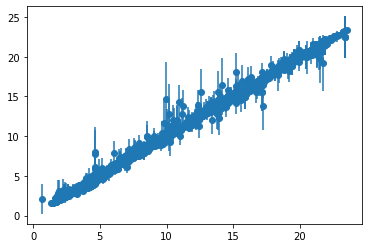

In [ ]:
predictions = []
for model in models:
    prediction = model.predict(df_train_stratified[FEATURES])
    predictions.append(prediction)
    
predictions = np.array(predictions)
plt.errorbar(df_train_stratified[TARGET],np.mean(predictions,axis = 0), yerr=np.std(predictions,axis = 0), linestyle="None")
plt.scatter(df_train_stratified[TARGET],np.mean(predictions,axis = 0))

sites that were not in the training set but in the training structures

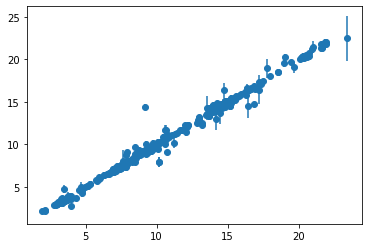

In [ ]:
predictions = []
for model in models:
    prediction = model.predict(df_test_stratified[FEATURES])
    predictions.append(prediction)
    
predictions = np.array(predictions)
plt.errorbar(df_test_stratified[TARGET],np.mean(predictions,axis = 0), yerr=np.std(predictions,axis = 0), linestyle="None")
plt.scatter(df_test_stratified[TARGET],np.mean(predictions,axis = 0))

### Test set

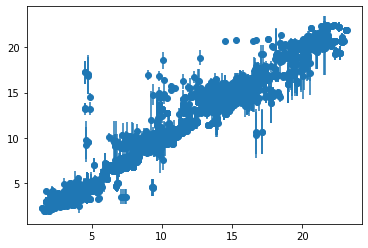

In [ ]:
predictions_new = []
for model in models:
    prediction = model.predict(df_site_test[FEATURES])
    predictions_new.append(prediction)
    
predictions_new = np.array(predictions_new)
plt.errorbar(df_site_test[TARGET],np.mean(predictions_new,axis = 0), yerr=np.std(predictions_new,axis = 0), linestyle="None")
plt.scatter(df_site_test[TARGET],np.mean(predictions_new,axis = 0))

In [ ]:
Cvs = predict_Cv_ensemble_dataset(models=models, FEATURES=FEATURES, df_features=df_site_test, temperature=temperature)

In [ ]:
df_structures.head()

,Unnamed: 0,mass,atom_types,Cv_molar_250.00,Cv_gravimetric_250.00,Cv_molar_275.00,Cv_gravimetric_275.00,Cv_molar_300.00,Cv_gravimetric_300.00,Cv_molar_325.00,Cv_gravimetric_325.00,Cv_molar_350.00,Cv_gravimetric_350.00,Cv_molar_375.00,Cv_gravimetric_375.00,Cv_molar_400.00,Cv_gravimetric_400.00,structure_type
0,12022N2,2283.09632,"{1.0, 5.0, 6.0, 7.0, 8.0, 30.0}",8.286131,0.791196,9.069603,0.866005,9.830723,0.938680,10.564779,1.008771,11.268213,1.075938,11.938615,1.139951,12.574627,1.200680,COF
1,13180N3,872.83788,"{8.0, 1.0, 6.0, 7.0}",7.477927,0.839602,8.240734,0.925248,8.987792,1.009126,9.713325,1.090587,10.412548,1.169094,11.081902,1.244248,11.719076,1.315788,COF
2,13181N3,904.98748,"{1.0, 6.0, 7.0, 8.0, 14.0}",8.020889,0.868572,8.757656,0.948356,9.478630,1.026429,10.178462,1.102213,10.852674,1.175223,11.497930,1.245097,12.112071,1.311602,COF
3,16050N2,2029.42960,"{1.0, 5.0, 6.0, 7.0, 8.0, 28.0}",7.862489,0.736105,8.673619,0.812045,9.461410,0.885800,10.220993,0.956914,10.948731,1.025046,11.642146,1.089965,12.299814,1.151538,COF
4,18150N2,1672.45428,"{1.0, 6.0, 7.0, 8.0, 17.0}",9.720576,0.755581,10.451999,0.812435,11.151413,0.866800,11.819037,0.918695,12.454745,0.968108,13.058391,1.015030,13.630034,1.059464,COF


In [ ]:
for ent in Cvs:
    ent["Cv_gravimetric"]=df_structures.loc[df_structures["Unnamed: 0"]==ent["name"]][f"Cv_gravimetric_{temperature}"].values[0]

In [ ]:
df_Cvs = pd.DataFrame(Cvs)

In [ ]:
df_Cvs

,name,Cv_gravimetric_250.00_mean,Cv_gravimetric_250.00_std,Cv_molar_250.00_mean,Cv_molar_250.00_std,Cv_gravimetric
0,ITT,0.643963,0.002503,12.897358,0.050134,0.666480
1,NPT,0.629197,0.006899,12.601625,0.138179,0.603253
2,RWY,0.628345,0.010427,12.584565,0.208832,0.601828
3,SAS,0.648401,0.006572,12.986230,0.131625,0.604195
4,VFI,0.651207,0.004562,13.042448,0.091364,0.663883
...,...,...,...,...,...,...
107,RSM1878,0.715236,0.004535,9.562994,0.060641,0.737555
108,RSM1883,0.687767,0.003486,9.349903,0.047386,0.695340
109,RSM1885,0.751171,0.006781,7.830025,0.070685,0.765619
110,RSM1887,0.798503,0.009737,8.749120,0.106684,0.716188


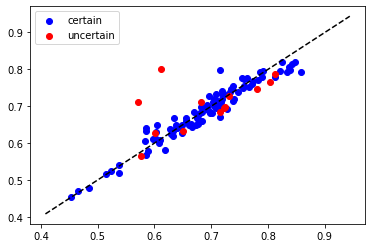

In [ ]:
certain=df_Cvs.loc[df_Cvs[f"Cv_gravimetric_{temperature}_std"]<0.01]
uncertain=df_Cvs.loc[df_Cvs[f"Cv_gravimetric_{temperature}_std"]>=0.01]
plt.scatter(certain["Cv_gravimetric"],certain[f"Cv_gravimetric_{temperature}_mean"],label="certain",c="b")
plt.scatter(uncertain["Cv_gravimetric"],uncertain[f"Cv_gravimetric_{temperature}_mean"],label="uncertain",c="r")
xr=np.linspace(0.9*min(df_Cvs["Cv_gravimetric"]),1.1*max(df_Cvs["Cv_gravimetric"]),100)
plt.plot(xr,xr,"k--")
plt.legend()